# Computer Vision Project
Sarah Reischenböck (S2210454018), Johanna Schmid (S2210454020), Arnold Stelzer (S2210454023)

Wir versuchen Bilder von Wasser und Feuerpokemon zu klassifizieren. Feuerpokemon sind meist orange/rot, während Wasserpokemon oft blau sind.

Als Experimente haben wir uns das Verändern der Batch size für den iterativen Trainingsprozess, das Verändern der Anzahl der Epochen, das Entfernen von Schichten aus dem Modell, sowie das Verändern der Farbe unserer Trainingsbilder überlegt.

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import itertools


2023-11-29 13:11:18.340065: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:11:18.344291: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 13:11:18.393142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:11:18.393218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:11:18.395320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Load image data

In [2]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

# dataset that lists all image files in the direct subfolders of example_training_data
image_files = tf.data.Dataset.list_files([f"./training_data/*/*{t}" for t in ["jpeg", "jpg", "png"]])


def load_and_preprocess_image(path):
    # Load the image
    image = tf.io.decode_image(
        tf.io.read_file(path),
        channels=3, dtype=tf.float32, expand_animations=False)
    image = tf.image.resize(image, size=[IMG_HEIGHT, IMG_WIDTH])    

    # We only flip the images left and right because we don't have pictures that are upside down
    image = tf.image.random_flip_left_right(image)
    return image

def extract_label_from_path(path):
    # Extract the first subfolder name as the label
    label = tf.strings.split(path, os.sep)[-2]        
    return label_to_int(label)
    
label_to_int = tf.keras.layers.StringLookup(
    vocabulary=[b"water", b"fire"],
    output_mode="one_hot",
    num_oov_indices=0)

image_files_list = [file_path.numpy().decode("utf-8") for file_path in image_files]

def split_and_load_data(batch_size):
    # Calculate the split sizes
    num_images = len(image_files_list)
    # we tried 0.8 before but then our model does not work. We think we do not have enough training data.
    train_size = int(0.9 * num_images)
    val_size = num_images - train_size
    
    tf.random.shuffle(image_files_list)
    
    # Create TensorFlow datasets from lists
    train_dataset = tf.data.Dataset.from_tensor_slices(image_files_list[:train_size])
    val_dataset = tf.data.Dataset.from_tensor_slices(image_files_list[train_size:])
    
    training_data = train_dataset.map(lambda x: (load_and_preprocess_image(x), extract_label_from_path(x)))
    validation_data = val_dataset.map(lambda x: (load_and_preprocess_image(x), extract_label_from_path(x)))
    
    training_data = training_data.batch(batch_size)
    validation_data = validation_data.batch(batch_size)
    return (training_data, validation_data)

(training_data, validation_data) = split_and_load_data(batch_size)


/opt/conda/lib/python3.11/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


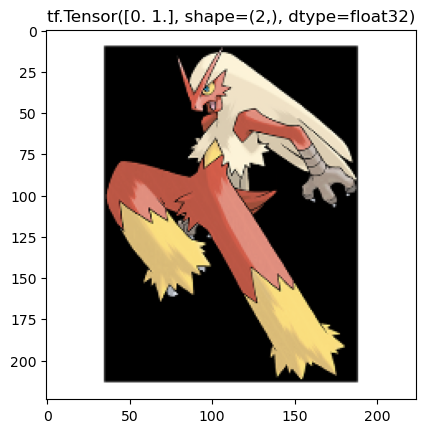

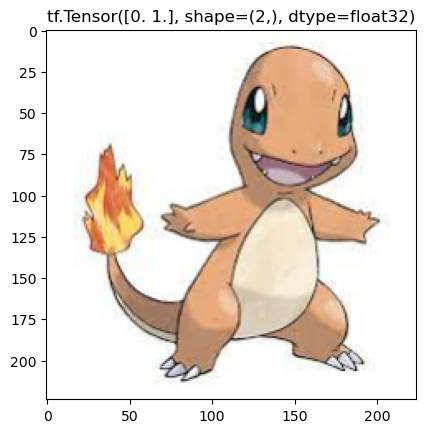

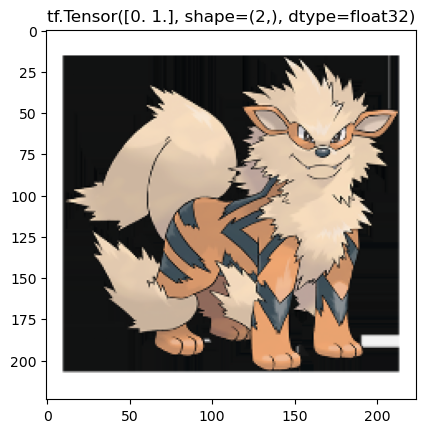

In [3]:
for img, label in validation_data.take(1):
    for i in range(img.shape[0]):
        plt.figure()
        plt.title(str(label[i]))
        plt.imshow(img[i, ...])

## Data Augmentation and Preprocessing

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

])

In [5]:
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])

## Create model

In [6]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        
        data_preprocessing,
        data_augmentation,
        
        tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
        tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
        tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
        tf.keras.layers.Flatten(),
                
        tf.keras.layers.Dense(128, activation='relu'),            
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model
model = create_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                 

## Train model

In [7]:
def compile_model(model):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model
model = compile_model(model)

In [8]:
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.6932 - accuracy: 0.3636 - val_loss: 0.7176 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 1s 808ms/step - loss: 0.6904 - accuracy: 0.5455 - val_loss: 0.8628 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 1s 810ms/step - loss: 0.6875 - accuracy: 0.5455 - val_loss: 0.7792 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 1s 725ms/step - loss: 0.6834 - accuracy: 0.5455 - val_loss: 0.7522 - val_accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 1s 781ms/step - loss: 0.6755 - accuracy: 0.5455 - val_loss: 0.7766 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 1s 768ms/step - loss: 0.6497 - accuracy: 0.5455 - val_loss: 0.5792 - val_accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 1s 772ms/step - loss: 0.6540 - accuracy: 0.5000 - val_loss: 1.3731 - val_accuracy: 0.0000e+00

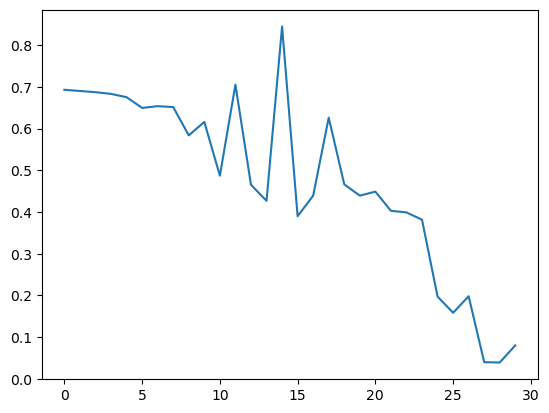

In [9]:
plt.plot(history.history['loss'])

## Predict test data, plot confusion matrix and roc curve

In [10]:
# Load test data
def load_test_data(batch_size):
    test_image_files = tf.data.Dataset.list_files([f"./test_data/*/*.{t}" for t in ["jpeg", "jpg", "png"]])
    test_image_files_list = [file_path.numpy().decode("utf-8") for file_path in test_image_files]
    test_dataset = tf.data.Dataset.from_tensor_slices(test_image_files_list)
    test_data = test_dataset.map(lambda x: (load_and_preprocess_image(x), extract_label_from_path(x)))
    test_data = test_data.batch(batch_size)
    return test_data

test_data = load_test_data(batch_size)

1/1 [==============================] - 0s 496ms/step
Accuracy: 0.9285714285714286


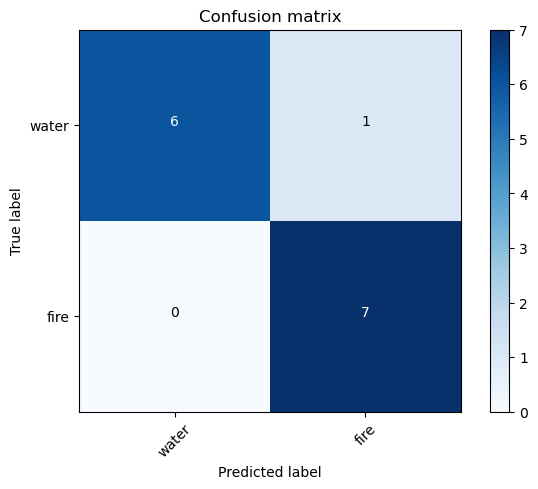

In [11]:
predictions = model.predict(test_data)

def generate_confusion_matrix(m, data):
    # Predict the labels
    predicted_class_indices = np.argmax(predictions, axis=1)
    
    # Extract true labels from test_data
    true_labels = np.concatenate([y.numpy() for _, y in test_data], axis=0)
    true_class_indices = np.argmax(true_labels, axis=1)  # Convert boolean to integer (fire: 1, water: 0)
    
    # Generate the confusion matrix
    cm = confusion_matrix(true_class_indices, predicted_class_indices)
    return cm

def calculate_accuarcy():
    predicted_class_indices = np.argmax(predictions, axis=1)
    true_labels = np.concatenate([y.numpy() for _, y in test_data], axis=0)
    true_class_indices = np.argmax(true_labels, axis=1)  # Convert boolean to integer (fire: 1, water: 0)
    accuracy = accuracy_score(true_class_indices, predicted_class_indices)
    print("Accuracy:", accuracy)

    
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()

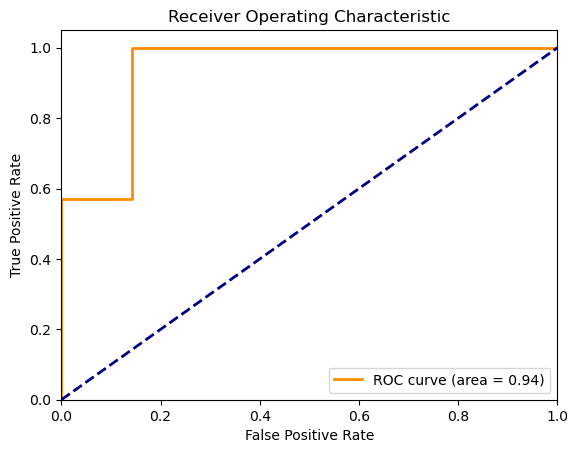

In [12]:
def plot_roc_curve(model, test_data):
    # Get probabilities for the positive class (assuming 'fire' is the positive class)
    predicted_class_indices = np.argmax(predictions, axis=1)
    # Extract true labels from test_data
    true_labels = np.concatenate([y.numpy() for _, y in test_data], axis=0)
    true_class_indices = np.argmax(true_labels, axis=1)  # Convert boolean to integer (fire: 1, water: 0)
    positive_class_probabilities = predictions[:, 1]
    
    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(true_class_indices, positive_class_probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(model, test_data)

Mit einer AUC von 0.87 haben wir ein besseres Modell bekommen, als wir erwartet haben. Wir sind von einem schlechteren Modell asugegangen, da wir nur sehr wenige Trainingsdaten haben. Das gute Ergebnis kommt unserer Meinung davon, dass es nur 2 Klassen gibt und die Bilder sich in Abhängigkeit ihrer Klasse im Hinblick auf ihre Farbe sehr stark voneinander unterscheiden. Es ist quasi sehr leicht zu erkennen, ob ein Bild ein Wasser- oder ein Feuerpokemon zeigt.

# Experiments

## 1. Batch Size verändern

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.6932 - accuracy: 0.4545 - val_loss: 0.7032 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 1s 929ms/step - loss: 0.6920 - accuracy: 0.5455 - val_loss: 0.7591 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 1s 859ms/step - loss: 0.6875 - accuracy: 0.5455 - val_loss: 0.8699 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 1s 969ms/step - loss: 0.6863 - accuracy: 0.5455 - val_loss: 0.6285 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 1s 746ms/step - loss: 0.6944 - accuracy: 0.4545 - val_loss: 0.7343 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 1s 903ms/step - loss: 0.6809 - accuracy: 0.5455 - val_loss: 0.8879 - val_accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 1s 861ms/step - loss: 0.6763 - accuracy: 0.5455 - val_loss: 0.9347 - val_accuracy: 0.0000e+00

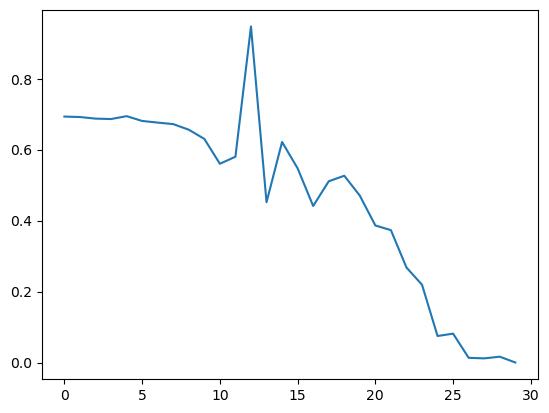

1/1 [==============================] - 0s 426ms/step
Accuracy: 0.9285714285714286


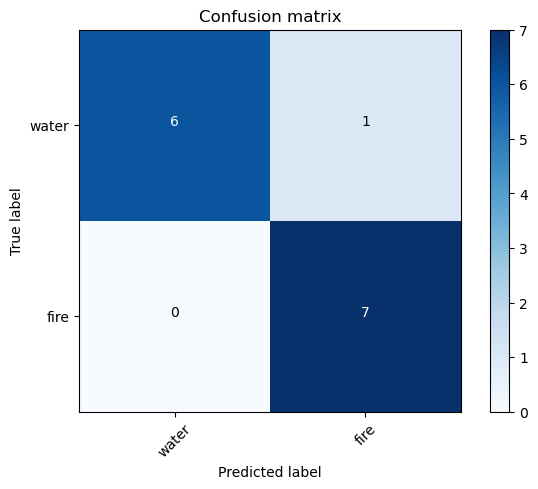

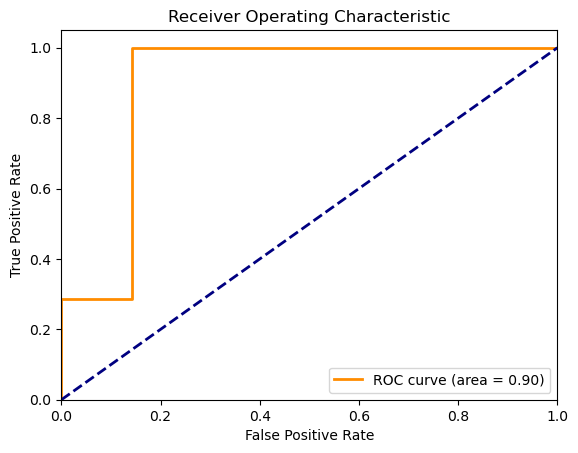

In [13]:
# Set batch size from 32 to 24
batch_size = 24;
(training_data, validation_data) = split_and_load_data(batch_size)
model = create_model()
model = compile_model(model)
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)
plt.plot(history.history['loss'])
plt.show()
test_data = load_test_data(batch_size)
predictions = model.predict(test_data)
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()
plot_roc_curve(model, test_data)



## Ergebnis: Batch Size von 32 auf 24
Das Modell ist minimal besser geworden.

Epoch 1/30
2/2 [==============================] - 2s 329ms/step - loss: 0.6927 - accuracy: 0.5909 - val_loss: 0.6466 - val_accuracy: 1.0000
Epoch 2/30
2/2 [==============================] - 0s 159ms/step - loss: 0.6918 - accuracy: 0.4545 - val_loss: 0.8178 - val_accuracy: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 0s 162ms/step - loss: 0.6631 - accuracy: 0.5455 - val_loss: 0.6850 - val_accuracy: 0.6667
Epoch 4/30
2/2 [==============================] - 0s 150ms/step - loss: 0.6344 - accuracy: 0.8182 - val_loss: 0.6430 - val_accuracy: 0.6667
Epoch 5/30
2/2 [==============================] - 0s 169ms/step - loss: 0.5102 - accuracy: 0.8636 - val_loss: 0.4301 - val_accuracy: 1.0000
Epoch 6/30
2/2 [==============================] - 0s 153ms/step - loss: 0.4034 - accuracy: 0.8636 - val_loss: 0.8268 - val_accuracy: 0.3333
Epoch 7/30
2/2 [==============================] - 0s 153ms/step - loss: 0.3924 - accuracy: 0.9091 - val_loss: 0.8674 - val_accuracy: 0.6667
Epoch 8/30
2/2 [

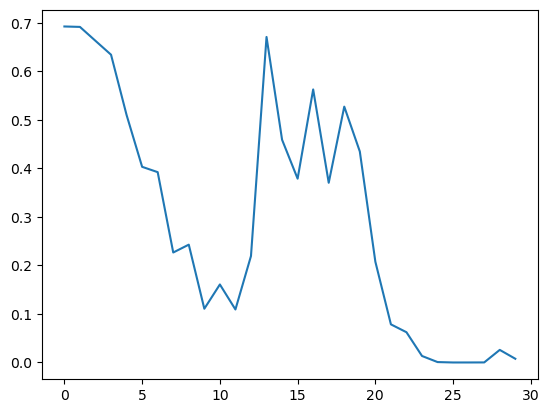

1/1 [==============================] - 0s 251ms/step
Accuracy: 0.7857142857142857


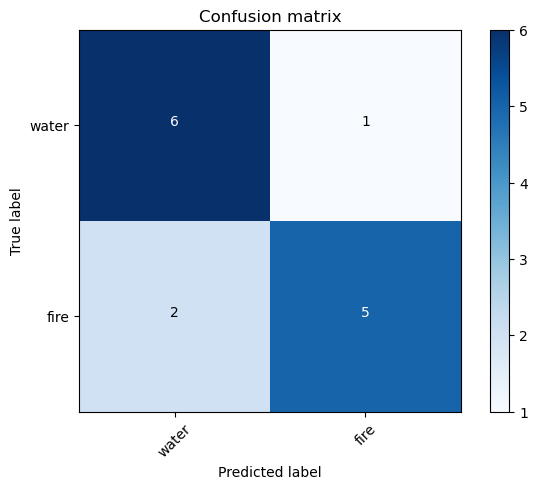

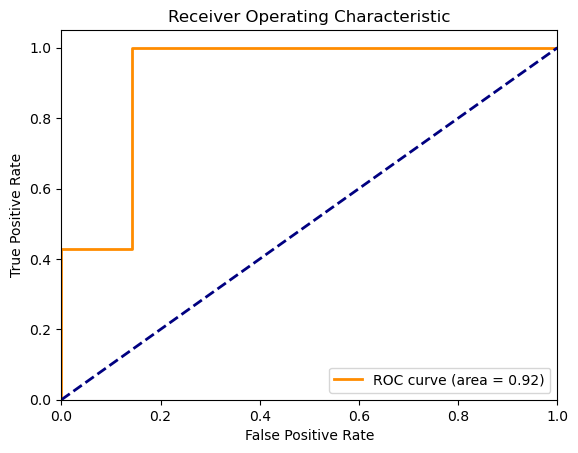

In [14]:
# Set batch size from 24 to 16
batch_size = 16;
(training_data, validation_data) = split_and_load_data(batch_size)
model = create_model()
model = compile_model(model)
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)
plt.plot(history.history['loss'])
plt.show()
test_data = load_test_data(batch_size)
predictions = model.predict(test_data)
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()
plot_roc_curve(model, test_data)



## Ergebnis Batch Size von 24 auf 16
Hier ist das Ergebnis nochmal besser geworden als bei Batch Size 24.

Wir können aber über die Batch Size keine allgmein gültige Aussage treffen, ob sie das Ergebnis verbessert oder verschlechtert. Es muss experimentiert werden, um den optimalen Wert für den gegebenen Use Case zu finden.

## 2. Epochs verringern

Hier gehen wir davon aus, dass das Verringern der Anzahl an Epochs zu einer deutlichen Verschlechterung führt, da die Epochs einen direkten Einfluss darauf haben wie lange das Modell trainiert wird. Je länger das Modell trainiert wird, desto besser sollte es werden.

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.4545 - val_loss: 0.6984 - val_accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 0s 444ms/step - loss: 0.6912 - accuracy: 0.5455 - val_loss: 0.7992 - val_accuracy: 0.0000e+00
Epoch 3/15
1/1 [==============================] - 0s 433ms/step - loss: 0.6860 - accuracy: 0.5455 - val_loss: 0.9506 - val_accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 0s 424ms/step - loss: 0.6847 - accuracy: 0.5455 - val_loss: 0.6847 - val_accuracy: 0.6667
Epoch 5/15
1/1 [==============================] - 0s 455ms/step - loss: 0.6790 - accuracy: 0.9545 - val_loss: 0.6721 - val_accuracy: 0.6667
Epoch 6/15
1/1 [==============================] - 0s 431ms/step - loss: 0.6605 - accuracy: 0.9545 - val_loss: 0.9084 - val_accuracy: 0.0000e+00
Epoch 7/15
1/1 [==============================] - 0s 427ms/step - loss: 0.6369 - accuracy: 0.5455 - val_loss: 0.7912 - val_accuracy: 0.3333
Epoch 8

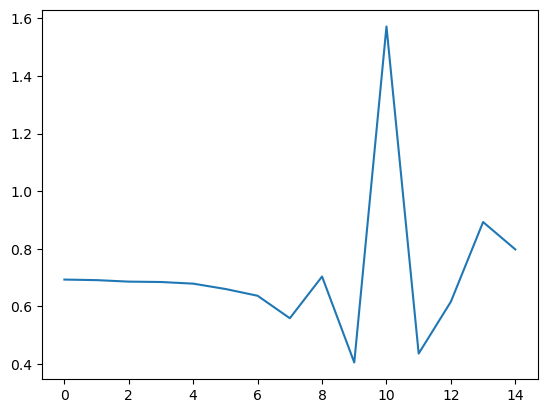

1/1 [==============================] - 0s 281ms/step
Accuracy: 0.5


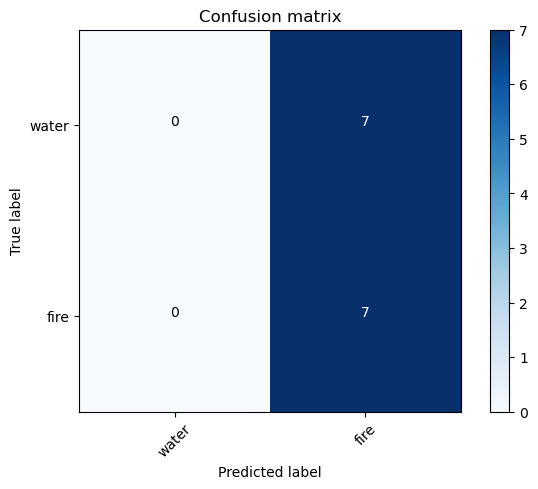

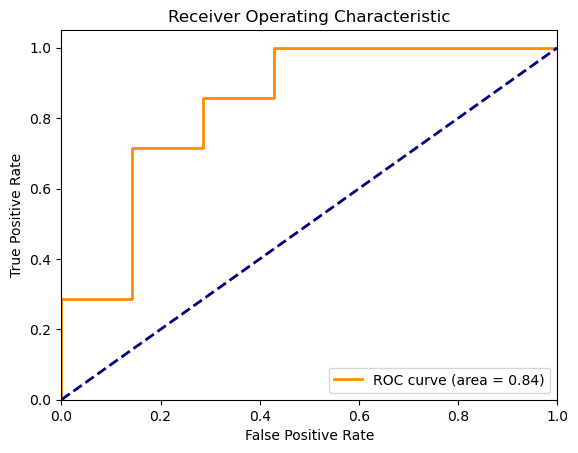

In [15]:
# set epochs from 30 to 15
batch_size = 32;
(training_data, validation_data) = split_and_load_data(batch_size)
model = create_model()
model = compile_model(model)
epochs = 15
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)
plt.plot(history.history['loss'])
plt.show()
test_data = load_test_data(batch_size)
predictions = model.predict(test_data)
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()
plot_roc_curve(model, test_data)


## Ergebnis Epochen von 30 auf 15
Wie erwartet ist das Ergebnis deutlich schlechter geworden.

## 3. Layer aus dem Modell entfernen

Hier gehen wir davon aus, dass es nicht unbedingt zu einer Verschlechterung der Vorhersage kommt. Das liegt daran, dass wie eingangs erwähnt, ein sehr einfacher Zusammenhang (Farbe rot oder blau) bestimmt, welche Klasse das Bild hat. Das bedeutet, das kein komplexes Modell benötigt wird, um die Bilder zu klassifizieren. Daher sollte es auch möglich sein, weniger Layer zu verwenden und ein ähnlich gutes Ergebnis zu bekommen.

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.6937 - accuracy: 0.2727 - val_loss: 0.6629 - val_accuracy: 1.0000
Epoch 2/30
1/1 [==============================] - 0s 415ms/step - loss: 0.6709 - accuracy: 0.7273 - val_loss: 1.1492 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 443ms/step - loss: 0.6673 - accuracy: 0.5455 - val_loss: 0.1720 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 419ms/step - loss: 0.8340 - accuracy: 0.4545 - val_loss: 0.4453 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 447ms/step - loss: 0.5567 - accuracy: 0.7727 - val_loss: 0.9936 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 0s 412ms/step - loss: 0.5892 - accuracy: 0.5909 - val_loss: 1.0088 - val_accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 0s 446ms/step - loss: 0.5932 - accuracy: 0.5909 - val_loss: 0.6432 - val_accuracy: 0.3333
Epoch 8/30


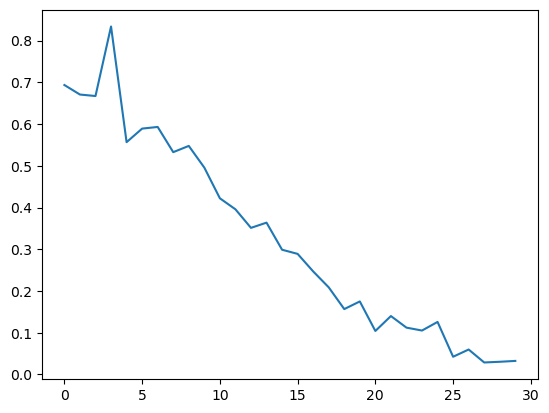

1/1 [==============================] - 0s 278ms/step
Accuracy: 0.9285714285714286


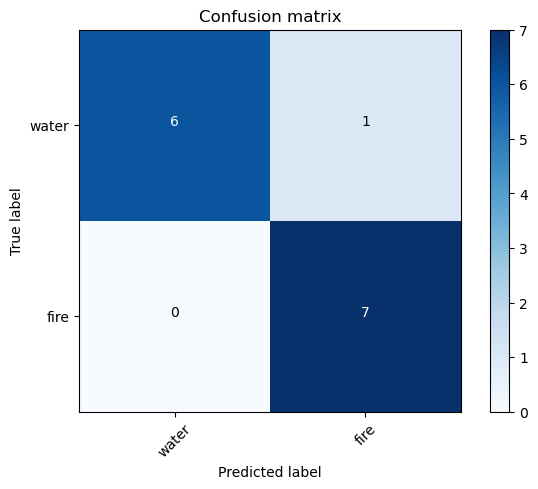

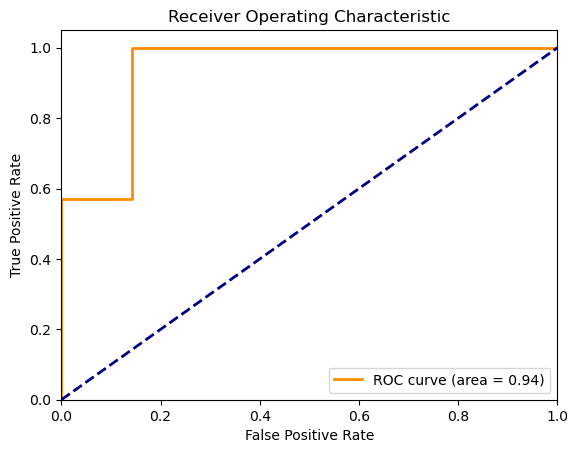

In [16]:
# remove layers
batch_size = 32;
(training_data, validation_data) = split_and_load_data(batch_size)
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        data_preprocessing,
        data_augmentation,
        tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation='relu'),            
        tf.keras.layers.Dense(2, activation='softmax')
    ])
model = compile_model(model)
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)
plt.plot(history.history['loss'])
plt.show()
test_data = load_test_data(batch_size)
predictions = model.predict(test_data)
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()
plot_roc_curve(model, test_data)

## Ergebnis Entfernen der meisten Schichten
Das Ergebnis ist sogar besser geworden nachdem wir die meisten Layers entfernt haben. Unsere Vermutung wurde also bestätigt.

## 4. Farbe der Trainingsbilder entfernen

Dieses Experiment machen wir um unsere Annahme zu bestätigen/verwerfen, dass die Farbe ein extrem wichtiges Merkmal ist, um die Bilder zu klassifizieren. Wir gehen davon aus, dass das Ergebnis deutlich schlechter wird, wenn wir die Farbe der Bilder entfernen.

Wir haben z.B. einen roten Fisch in unseren Testdaten, der oft als Feuerpokémon missklassifiziert wird.

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.7006 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 441ms/step - loss: 0.6922 - accuracy: 0.5455 - val_loss: 0.7902 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 1s 502ms/step - loss: 0.6892 - accuracy: 0.5455 - val_loss: 0.8614 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 0s 476ms/step - loss: 0.6897 - accuracy: 0.5455 - val_loss: 0.7134 - val_accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 482ms/step - loss: 0.6896 - accuracy: 0.5455 - val_loss: 0.7396 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 0s 480ms/step - loss: 0.6853 - accuracy: 0.5455 - val_loss: 0.8577 - val_accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 0s 479ms/step - loss: 0.6844 - accuracy: 0.5455 - val_loss: 0.8200 - val_accuracy: 0.0000

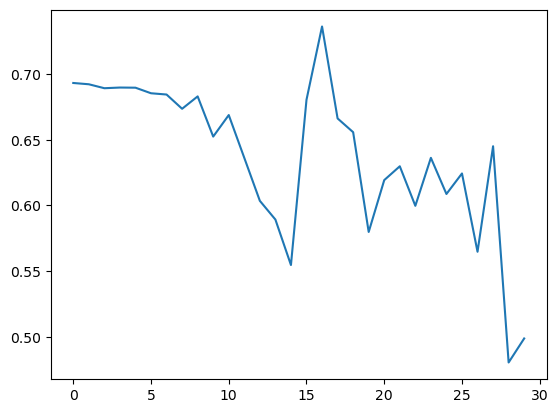

1/1 [==============================] - 0s 289ms/step
Accuracy: 0.6428571428571429


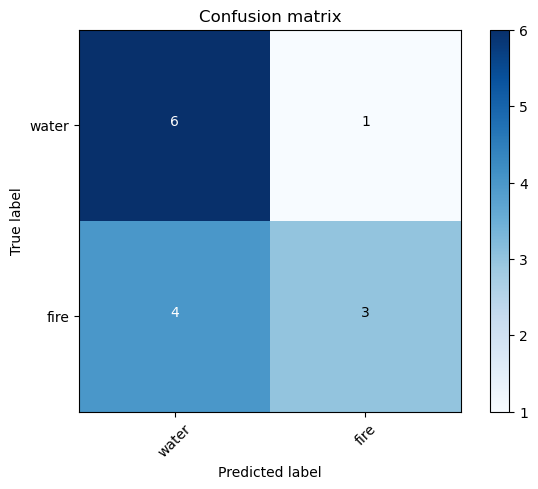

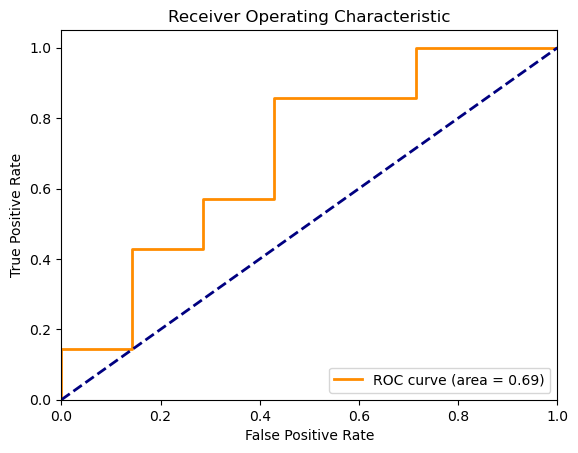

In [17]:
batch_size = 32;
(training_data, validation_data) = split_and_load_data(batch_size)

def rgb_to_grayscale(rgb):
    return tf.image.rgb_to_grayscale(rgb)
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x))
])
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        data_preprocessing,
        data_augmentation,
        tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
        tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
        tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation='relu'),            
        tf.keras.layers.Dense(2, activation='softmax')
    ])
model = compile_model(model)
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)
plt.plot(history.history['loss'])
plt.show()
test_data = load_test_data(batch_size)
predictions = model.predict(test_data)
calculate_accuarcy()
cm = generate_confusion_matrix(model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()
plot_roc_curve(model, test_data)

## Ergebnis
Unsere Annahme wurde bestätigt. Wie erwartet, ist Farbe sehr wichtig für das Modell. Das Ergebnis ist deutlich schlechter geworden.

# Save model

In [18]:
model.save('pokemon.keras') # generates keras format
model.save('pokemon.h5') # generates hdf5 format

model.export('result') # creates a SavedModel (for e.g. TF Serving)

model.save_weights('result') # saves only the weights of the model, not the model itself
model.load_weights('result') # restores the model from the wieghts

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: result/assets


INFO:tensorflow:Assets written to: result/assets


Saved artifact at 'result'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_6')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140557507443984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557507444560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557507444176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557503195728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557503189584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557503196112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557553396496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140557507444368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140555430063248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140555430062288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140555430064976: TensorSpec(s

# Load Model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 224, 224, 1)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, None)    0         
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 16)      416       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 53, 53, 32)        0         
 ng2D)                                                

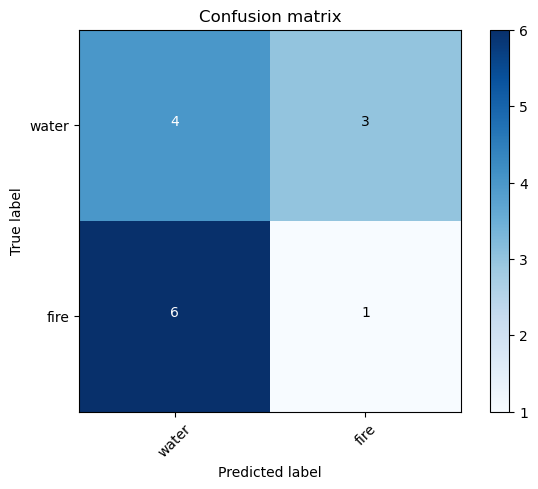

In [19]:
loaded_model = tf.keras.models.load_model('pokemon.keras', safe_mode=False)
loaded_model.summary()
#history = loaded_model.fit(
#  training_data,
#  validation_data=validation_data,
#  epochs=epochs
#)
test_data = load_test_data(batch_size)
cm = generate_confusion_matrix(loaded_model, test_data)
plot_confusion_matrix(cm, classes=['water', 'fire'])  # Note: Order of classes matches boolean conversion
plt.show()